In [220]:
import laspy as lp
import numpy as np
import matplotlib.pyplot as plt


def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)


rasantes = {
    'km11': 2300.382,  
    'km12': 2300.345,   
    'km13': 2300.372,
    '3a': 2300.305,
    '2a': 2300.700,
    'pam2': 2300.618  
}

salmueras = {
    'km11': 2300.866,
    'km12': 2300.582,
    'km13': 2300.647,
    'pam2': 2302.185,
    '2a': 2301.129,
    '3a': 2300.978
}

pozas = {
    "km11": [
        (565069.970, 7403193.413, 2300.565),
        (565191.968, 7403283.869, 2300.542),
        (565195.699, 7403102.580, 2300.527)
    ],
    "km12": [
        (565328.392, 7403116.663, 2300.408),
        (565334.326, 7403279.183, 2300.385),
        (565451.299, 7403199.079, 2300.392)
    ],
    "km13": [
        (565613.237, 7403203.757, 2300.486),
        (565724.189, 7403120.616, 2300.371),
        (565719.644, 7403294.142, 2300.385)
    ],
    "pam2": [
        (558854.768, 7394807.683, 2301.750),
        (558854.742, 7394746.032, 2301.614),
        (558896.341, 7394774.391, 2301.863)
    ],
    "2a": [
        (559312.399, 7394750.575, 2300.889),
        (559258.428, 7394683.524, 2300.824),
        (559257.914, 7394807.991, 2300.878)
    ],
    "3a": [
        (559421.390, 7394768.078, 2300.679),
        (559527.662, 7394863.970, 2300.698),
        (559533.954, 7394694.214, 2300.640)
    ]
}


DATE = 29032025
H = 100
V = 7
F = 100
C = 'plena_luz'
T = 'sin talud'
POZA = 'km13'
S = 'sectorb'
PATH_LAS = f'data/vuelos_marzos/{DATE}/{T}/{H}m_{V}ms_{F}khz_{C}/{POZA}_{S}_{H}m_{V}ms_{F}khz_{C}_0_0.las' 
#PATH_LAS = f'data/vuelos_marzos/{DATE}/{H}m_{V}ms_{F}khz_{C}/{POZA}_{H}m_{V}ms_{F}khz_{C}_0_0.las' 

LIMIT = -1

rasante = rasantes.get(POZA, None)
c_salmuera_sqm = salmueras.get(POZA, None)
i_puntos = pozas.get(POZA,None)

print(f'{POZA}\nRasante: {rasante}\nCota Salmuera SQM: {c_salmuera_sqm}\nPuntos Control: {i_puntos}')

km13
Rasante: 2300.372
Cota Salmuera SQM: 2300.647
Puntos Control: [(565613.237, 7403203.757, 2300.486), (565724.189, 7403120.616, 2300.371), (565719.644, 7403294.142, 2300.385)]


In [221]:
las = read_las_file(PATH_LAS)

points = np.vstack((las.x, las.y, las.z)).transpose()
data_points = np.hstack((points,
                        np.expand_dims(las.return_number, -1),
                        np.expand_dims(las.number_of_returns, -1)))

#first = data_points[(data_points[:,-2] == 1) & (data_points[:,-1] == 2)][:, :3]
one_return = data_points[(data_points[:, -1] == 1)][:, :3]

x, y, z = one_return[:,0], one_return[:,1], one_return[:,2] 


print(f'Cota Sal promedio {POZA}: {np.mean(z[z<c_salmuera_sqm])}')


Cota Sal promedio km13: 2300.405067361323


In [222]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd

def find_best_gmm(data, max_components=2, criterion='aic', **kwargs):
    '''
    Find the best number of components for a Gaussian Mixture Model using AIC or BIC. 
    '''

    n_components_range = range(1, max_components + 1)
    criterions, means = [], []

    if criterion not in ['aic', 'bic']:
        raise ValueError("Invalid criterion. Use 'bic' or 'aic'.")

    for n in n_components_range:
        try:
            gmm = GaussianMixture(n_components=n, **kwargs)
            gmm.fit(data)
            if criterion == 'bic':
                criterions.append(gmm.bic(data))
            else:
                criterions.append(gmm.aic(data))
            means.append(gmm.means_)
        except ValueError as e:
            print(f"Error fitting GMM with {n} components: {e}")
            break

    return n_components_range[np.argmin(criterions)], means[np.argmin(criterions)]


In [223]:
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

points = np.vstack((x, y)).transpose()
kdtree = KDTree(points)
radius = 0.5

for idx, (xi, yi, cota_sal_sqm) in enumerate(i_puntos, start=1):
    point_of_interest = np.array([xi, yi])
    indices = kdtree.query_ball_point(point_of_interest, radius)
    cota_sal = np.mean(z[indices])
    #n, cota_sal = find_best_gmm(np.expand_dims(z[indices],-1), max_components=1)
    print(f'Cota sal SQM: {cota_sal_sqm}\nCota lidar {cota_sal}\n')


# for idx, (xi, yi, cota_sal_sqm) in enumerate(i_puntos, start=2):
#     point_of_interest = np.array([xi, yi])
#     indices = kdtree.query_ball_point(point_of_interest, radius)
#     xa, ya, za = x[indices], y[indices], z[indices]
    
#     # Calculamos la cota lidar (usando tu método preferido)
#     cota_sal = np.mean(za)
#     #n, cota_sal = find_best_gmm(np.expand_dims(z[indices],-1), max_components=1)
    
#     # Configuración de la figura con dos subplots
#     fig = plt.figure(figsize=(14, 6))
    
#     # Gráfico 3D
#     ax1 = fig.add_subplot(121, projection='3d')
#     ax1.set_zlim(za.min() - 0.1, za.max() + 0.1)
    
#     ax1.scatter(xa, ya, za, c='blue', s=1)
#     ax1.set_title(f'{POZA} Punto {idx} {H}-{V}-{F}')
#     ax1.set_xlabel('X')
#     ax1.set_ylabel('Y')
#     ax1.set_zlabel('Z')
    
#     # Corte lateral (X-Z)
#     ax2 = fig.add_subplot(122)
#     ax2.set_ylim(za.min() - 0.1, za.max() + 0.1)
#     ax2.scatter(xa, za, c='blue', s=1, alpha=0.5)
#     ax2.axhline(cota_sal, color='red', linestyle='--', label='Cota Sal Lidar')
#     ax2.axhline(cota_sal_sqm, color='green', linestyle='--', label='Cota Sal SQM')
#     ax2.set_xlabel('X')
#     ax2.set_ylabel('Z')
#     ax2.set_title('Corte Lateral X-Z')
#     ax2.legend()
#     ax2.grid(True)

#     plt.tight_layout()
#     plt.show()

Cota sal SQM: 2300.486
Cota lidar nan

Cota sal SQM: 2300.371
Cota lidar 2300.4288718929256

Cota sal SQM: 2300.385
Cota lidar 2300.3780754257905



[1070  411 1578] [ 538 1269 1312]
Number of bands: 1
Width: 1793
Height: 2017
CRS: None
Transform: 
| 0.15, 0.00, 559343.00|
| 0.00,-0.15, 7394923.82|
| 0.00, 0.00, 1.00|
Data type: float64


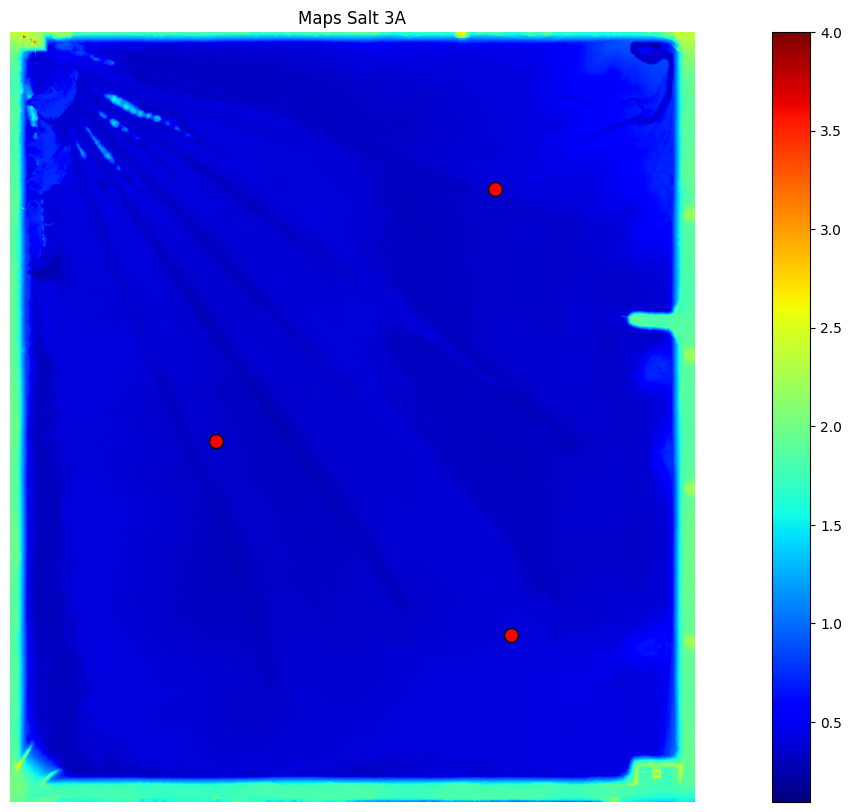

In [224]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt

POZA= '3a'

i_puntos = pozas.get(POZA,None)
tiff_path = f'dems/{POZA}.tiff'
output_path = f'{tiff_path.split(".")[0]}.png'

with rasterio.open(tiff_path) as src:
    data = src.read()
    
    transformer = rasterio.transform.AffineTransformer(src.transform)
    p = np.array([transformer.rowcol(x, y) for x,y,_ in i_puntos])
    x,y = p[:,0], p[:,1]
    print(x,y)
    # Print basic information about the raster
    print(f'Number of bands: {src.count}')
    print(f'Width: {src.width}')
    print(f'Height: {src.height}')
    print(f'CRS: {src.crs}')
    print(f'Transform: \n{src.transform}')
    print(f'Data type: {src.dtypes[0]}')

    # Display the image
    if src.count == 1:
        plt.figure(figsize=(20,10))
        plt.scatter(y,x, color='red', marker='o', s=100, edgecolor='black')
        plt.imshow(data[0], cmap='jet')
    else:
        plt.imshow(data.transpose(1, 2, 0))

    plt.title(f'Maps Salt {POZA.upper()}')
    plt.colorbar()
    plt.axis('off') 
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()